# Downloading and loading data

In [1]:
import os
import pandas as pd
import shutil
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
adsSales = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "thorgodofthunder/tvradionewspaperadvertising/versions/1",
    "Advertising.csv",
)

# Looking at Data Structure

In [2]:
adsSales.head() # First five rows
adsSales.info() # Type of attributes
adsSales.describe() # Data statistics for numeric attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

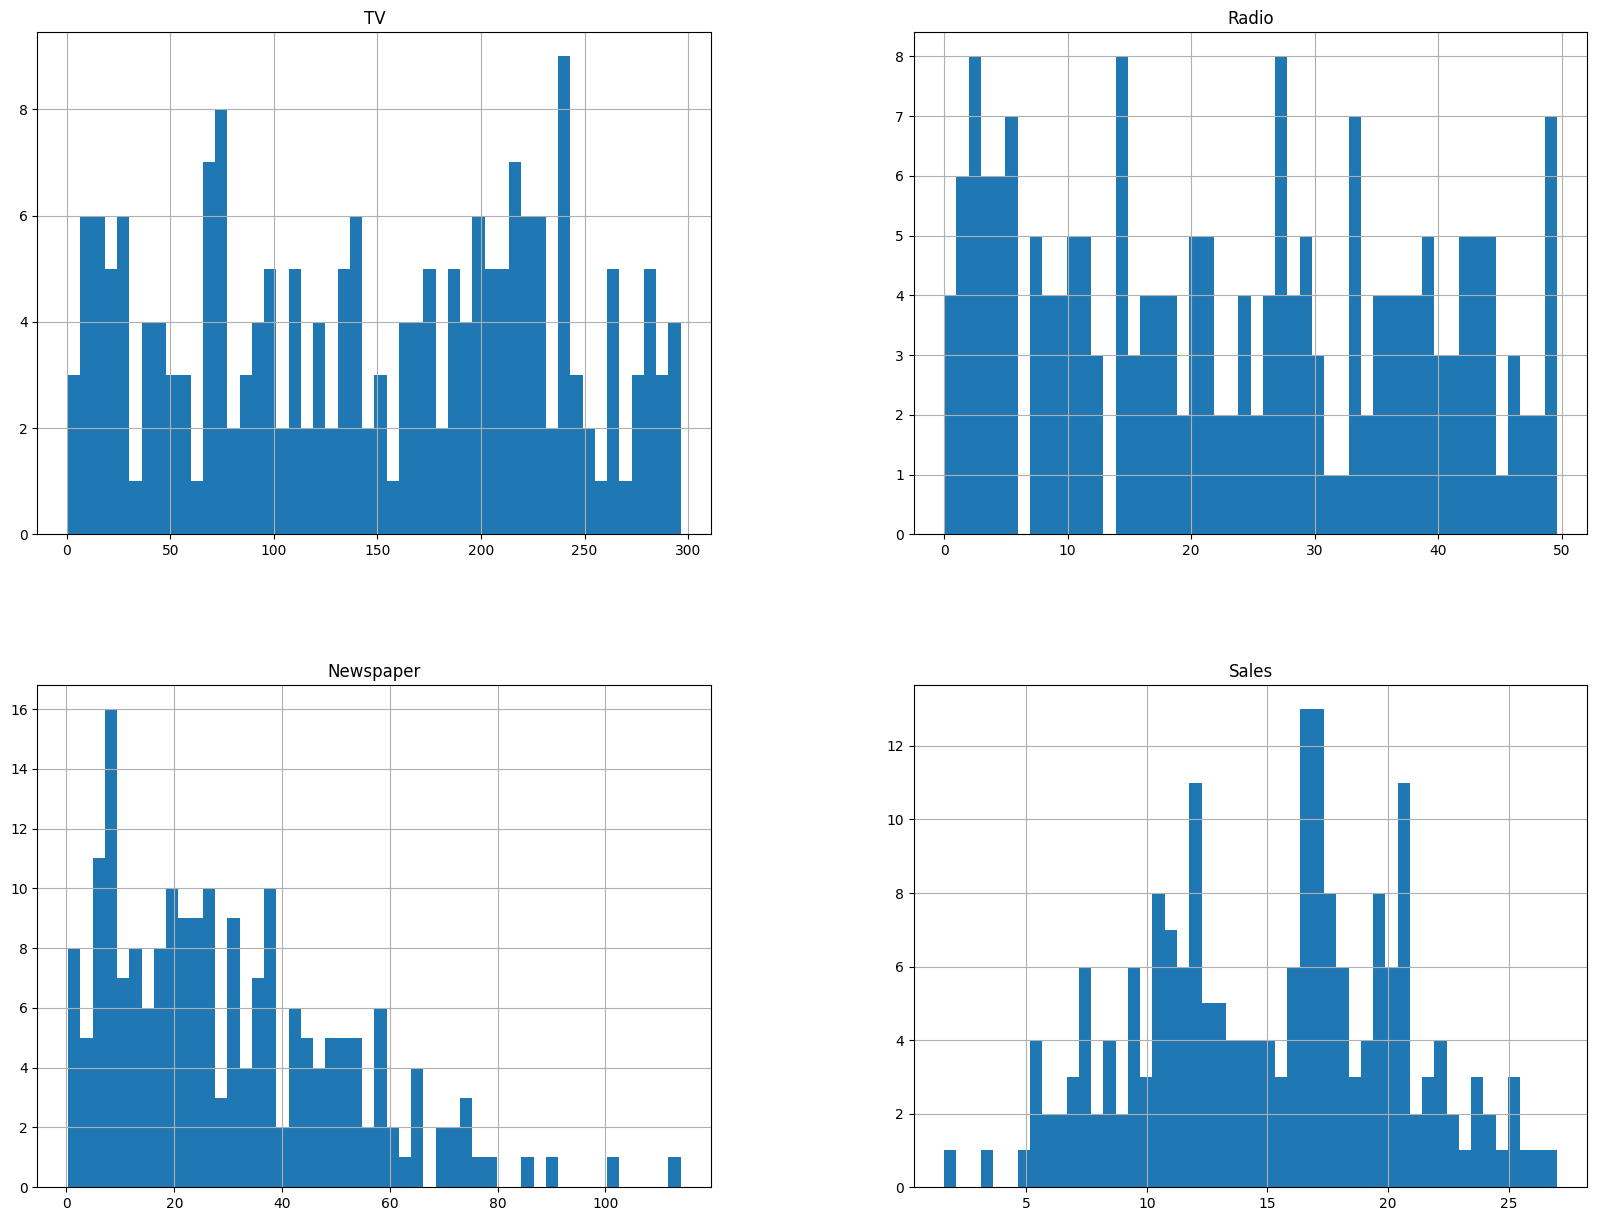

In [3]:
# Counts levels for categorical attributes (If applicable)
# Histogram of numeric attributes
%matplotlib inline
import matplotlib.pyplot as plt
adsSales.hist(bins=50, figsize=(20,15))

# Creating Test Set

<Axes: >

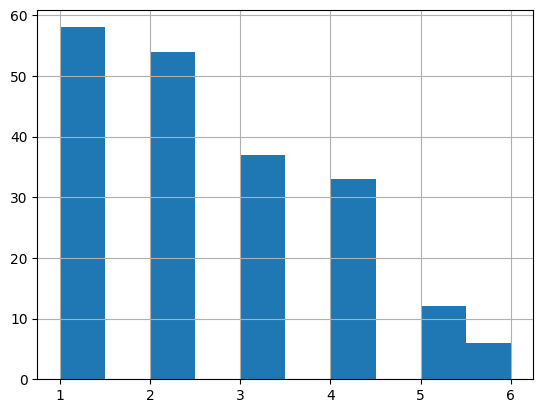

In [4]:
# Assume underlying strata for the newspapers
import numpy as np

# Creating newspaper categories
adsSales["Newspaper_cat"] = pd.cut(adsSales["Newspaper"],
                                   bins=[0., 15., 30., 45., 60., 75., np.inf],
                                   labels=[1, 2, 3, 4, 5, 6,])
adsSales["Newspaper_cat"].hist()


In [5]:
# Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(adsSales, adsSales["Newspaper_cat"]):
    strat_train_set = adsSales.loc[train_index]
    strat_test_set = adsSales.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("Newspaper_cat", axis=1, inplace=True)

# Discovering and Visualizing the Data

In [6]:
# Copying the training set
adsSales = strat_train_set.copy()

array([[<Axes: xlabel='TV', ylabel='TV'>,
        <Axes: xlabel='Radio', ylabel='TV'>,
        <Axes: xlabel='Newspaper', ylabel='TV'>,
        <Axes: xlabel='Sales', ylabel='TV'>],
       [<Axes: xlabel='TV', ylabel='Radio'>,
        <Axes: xlabel='Radio', ylabel='Radio'>,
        <Axes: xlabel='Newspaper', ylabel='Radio'>,
        <Axes: xlabel='Sales', ylabel='Radio'>],
       [<Axes: xlabel='TV', ylabel='Newspaper'>,
        <Axes: xlabel='Radio', ylabel='Newspaper'>,
        <Axes: xlabel='Newspaper', ylabel='Newspaper'>,
        <Axes: xlabel='Sales', ylabel='Newspaper'>],
       [<Axes: xlabel='TV', ylabel='Sales'>,
        <Axes: xlabel='Radio', ylabel='Sales'>,
        <Axes: xlabel='Newspaper', ylabel='Sales'>,
        <Axes: xlabel='Sales', ylabel='Sales'>]], dtype=object)

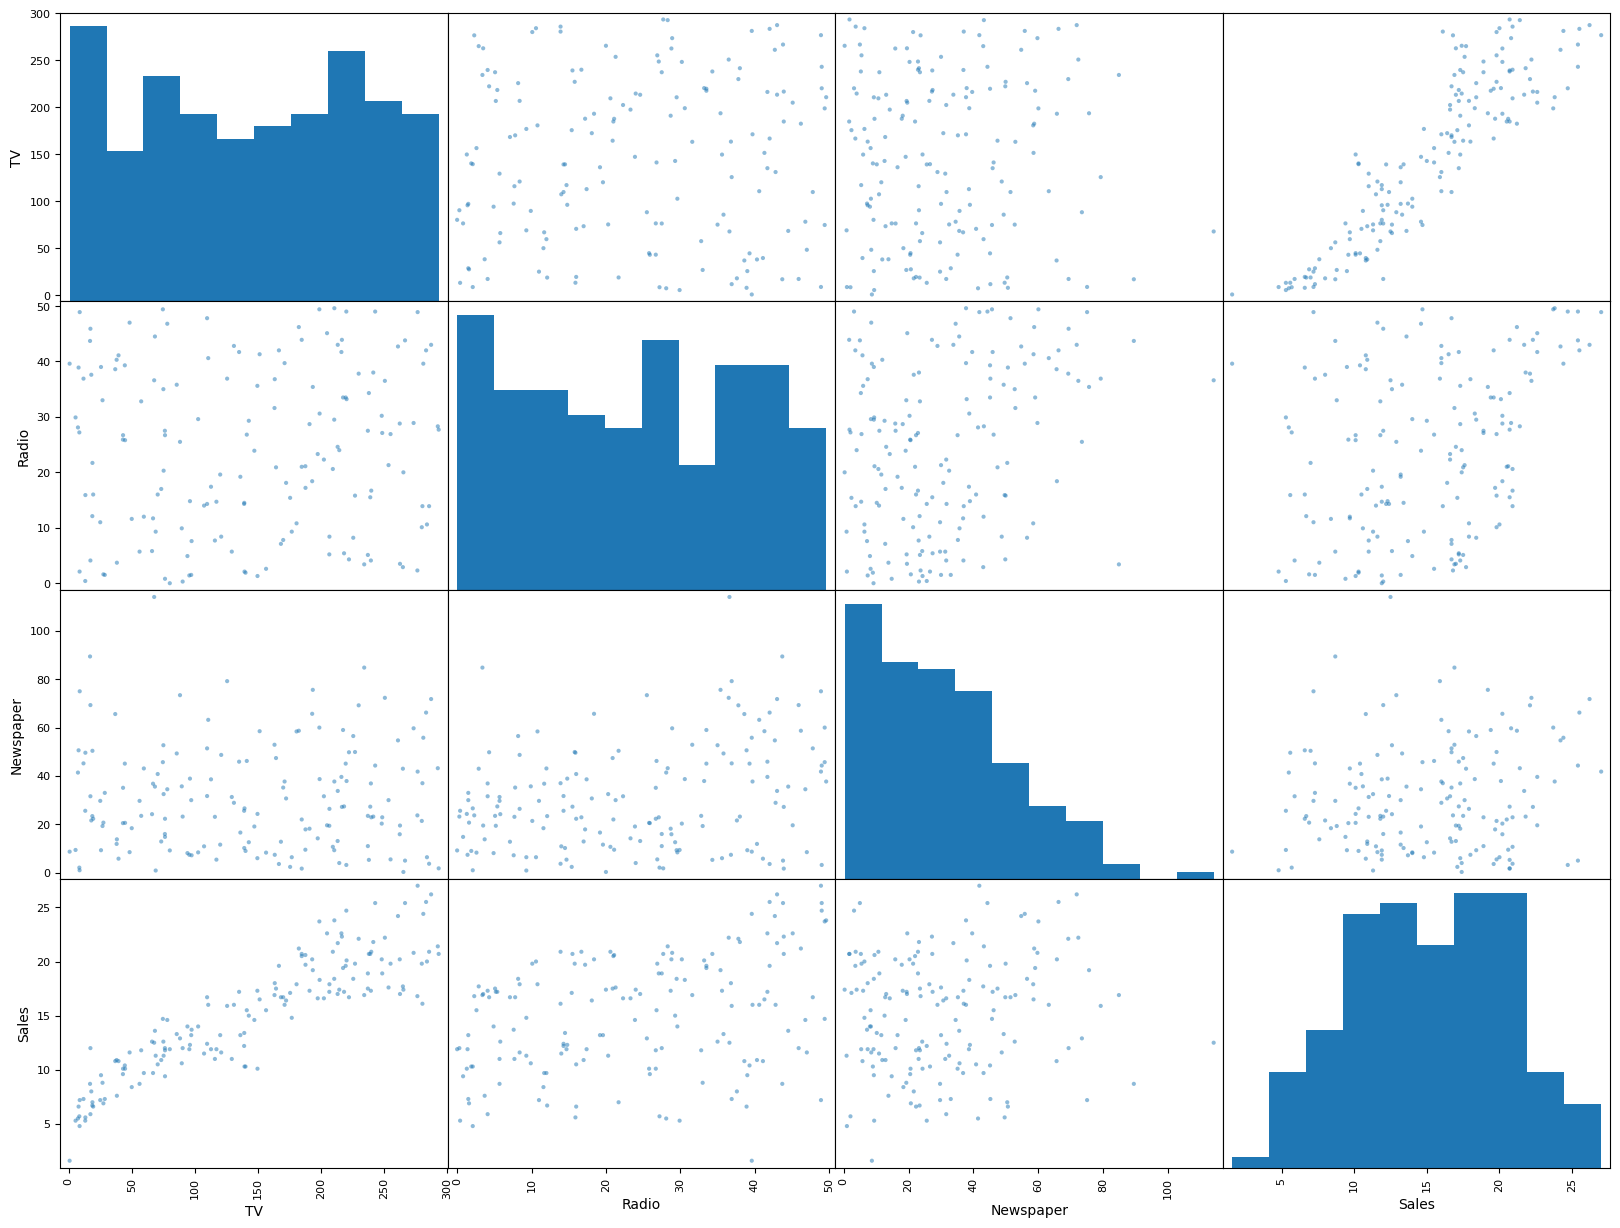

In [7]:
from pandas.plotting import scatter_matrix

## Looking for correlation
corr_matrix = adsSales.corr()
corr_matrix["Sales"].sort_values(ascending=False)

## One could decide to focus only on promising attributes (TV, Radio)
## for now we keep all three since they are not so many
scatter_matrix(adsSales, figsize=(20,15))

In [8]:
# Attribute transformation
adsSales["logRadio"] = np.log(adsSales["Radio"])
adsSales["logNewspaper"] = np.log(adsSales["Newspaper"])

# Correlation matrix
corr_matrix = adsSales.corr()
corr_matrix["Sales"].sort_values(ascending=False)

## Note: Log transformation does not improve correlation

/home/christian/Documents/Machine_learning/mlenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Sales           1.000000
TV              0.899607
Radio           0.347018
logRadio        0.339390
Newspaper       0.110879
logNewspaper    0.052109
Name: Sales, dtype: float64

# Preparing Data for ML Algorithms

In [9]:
## Note: This data is clean without missing data, so there is no need for imputation.
##       Further transformations besides the log-transform could be tested but we keep it simple.
##       Since there are no categorical attributes, there is no need for OneHotEncoding

# Fetching the training dataset again
adsSales = strat_train_set.drop("Sales", axis=1)
adsSales_labels = strat_train_set["Sales"].copy()

# Standardizing numeric attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline for numerical attributes, using a pipeline (just as an example)
num_pipeline = Pipeline([
    ('attribs_scaler', StandardScaler()),
])

## Full pipeline
num_attribs = list(adsSales)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
])

adsSales_prepared = full_pipeline.fit_transform(adsSales)

# Selecting and Training a Model

In [10]:
# Training and evaluating on the test set: Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = lin_reg.predict(adsSales_prepared)
lin_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

## Note: root mean squarred is quite small

np.float64(1.7103085869352868)

In [11]:
# Training and evaluating on the training set: Decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = tree_reg.predict(adsSales_prepared)
tree_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

## Note: Decision tree overfits the dataset

np.float64(0.0)

In [12]:
# Improving model evaluation: K-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import joblib

MODEL_PATH = os.path.join("models", "adsSales")

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print("")

def save_model(model, name="model", model_path=MODEL_PATH):
    os.makedirs(model_path, exist_ok=True)
    model_name = name + ".pkl"
    pkl_path = os.path.join(model_path, model_name)
    joblib.dump(model, pkl_path)

# Decision tree
scores = cross_val_score(tree_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
save_model(tree_reg, name="decision_tree", model_path=MODEL_PATH)

# Linear regression
scores = cross_val_score(lin_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)
save_model(lin_reg, name="linear_regression", model_path=MODEL_PATH)

# Random forest
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)
save_model(forest_reg, name="random_forest", model_path=MODEL_PATH)

# Support vector machine
svm_reg = SVR()
scores = cross_val_score(svm_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)
display_scores(svm_rmse_scores)
save_model(svm_reg, name="support_vector_machine", model_path=MODEL_PATH)

## Note: Random Forest has the smallest variance

Scores: [1.01612007 2.02962435 1.1757976  1.86178678 0.90242728 1.77869334
 0.85732141 1.18585412 2.03408456 1.35392947]
Mean: 1.4195638981587861
Standard deviation: 0.4403417298465266

Scores: [1.10895914 2.18412745 1.26507684 2.75586189 1.50899586 1.4607585
 1.78450846 1.77799454 1.6561925  1.5246694 ]
Mean: 1.70271445720721
Standard deviation: 0.450248964982293

Scores: [0.85283472 1.66530802 1.21818974 1.81540577 0.64462329 0.99179704
 1.0353085  1.04054796 1.69070963 1.54874469]
Mean: 1.2503469384046695
Standard deviation: 0.3817723256367218

Scores: [1.59929746 1.96122375 1.69226592 3.00020145 2.20959742 2.30676019
 2.78817874 2.02031988 1.91302083 1.16819561]
Mean: 2.065906124798157
Standard deviation: 0.5169979283620552



# Fine-Tuning the Best Model (Random Forest)

In [13]:
# Grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100, 150, 200], 'max_features': [6, 8, 10, 12]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(adsSales_prepared, adsSales_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [6, 8, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,150


In [14]:
# Grid search outcome

grid_search.best_params_ # Best model parameters
grid_search.best_estimator_ # Best estimator
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.588262065557472 {'max_features': 6, 'n_estimators': 3}
1.4166604656727029 {'max_features': 6, 'n_estimators': 10}
1.3901218971330853 {'max_features': 6, 'n_estimators': 30}
1.4134506535425992 {'max_features': 6, 'n_estimators': 50}
1.3682339141206814 {'max_features': 6, 'n_estimators': 100}
1.3630987257389353 {'max_features': 6, 'n_estimators': 150}
1.3770774856784556 {'max_features': 6, 'n_estimators': 200}
1.6775064166129967 {'max_features': 8, 'n_estimators': 3}
1.4544401844008568 {'max_features': 8, 'n_estimators': 10}
1.3901830415052858 {'max_features': 8, 'n_estimators': 30}
1.407842329595186 {'max_features': 8, 'n_estimators': 50}
1.3771056808575006 {'max_features': 8, 'n_estimators': 100}
1.364853057821406 {'max_features': 8, 'n_estimators': 150}
1.3758696420355372 {'max_features': 8, 'n_estimators': 200}
1.6773697995506072 {'max_features': 10, 'n_estimators': 3}
1.440801209397049 {'max_features': 10, 'n_estimators': 10}
1.4480428841869442 {'max_features': 10, 'n_estimators':

# Evaluating Model on Test Set

In [15]:
# Picking best model from grid search

final_model = grid_search.best_estimator_

In [16]:
# Defining test dataset

X_test = strat_test_set.drop("Sales", axis=1)
y_test = strat_test_set["Sales"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [17]:
# Running predictions on test set

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(0.9667352102135658)

In [18]:
# Finding generalization error with 95% confidence interval

from scipy import stats

confidence = 0.95
squarred_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squarred_errors)-1,
                        loc=squarred_errors.mean(),
                        scale=stats.sem(squarred_errors)))

array([0.62892707, 1.2139212 ])

# Saving the Model for Possible Launch and Monitoring

In [19]:
# Saving the model as joblib file
save_model(final_model, name="Random_forest_V1.1", model_path=MODEL_PATH)